# Evaluate the impact of the number of LSTM layer on attention

In [13]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from IPython.display import display, HTML
import sys
sys.path.append("./../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from os import path

In [15]:
import spacy
import pickle
import torch
import matplotlib.pyplot as plt

from data.collate import *
from data.archival_dataset import *
from data.pipeline import *
from helpers import hightlight_txt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [25]:
spacy_model = spacy.load('fr_core_news_md')
labels = ['neutral', 'entailment']
cache_path = path.join('..','src','_out')
data_path='.'
nb_data = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
class SpacyTokenPipeline:
	FULL_PIPE = ['tagger', 'ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel', 'lemmatizer',
	             'morphologizer', 'attribute_ruler', 'senter', 'sentencizer', 'tok2vec', 'transformer']
	
	def __init__(self, spacy_model):
		self.sm = spacy_model
		self.pipe = list(set(self.FULL_PIPE) - set('tok2vec'))
	
	def __call__(self, texts):
		return [[tk.text for tk in doc if tk.has_vector] for doc in self.sm.pipe(texts, disable=self.pipe)]
	
	def __str__(self):
		return 'spacyvec'

In [27]:
def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

In [28]:
testset = ArchivalDataset('test', cache_path=cache_path, shuffle=True, n=nb_data)
testset.data = testset.data[:nb_data].reset_index(drop=False)
testset.data['premise'] = ['.'.join(x.split('.')[:3]) for x in testset.data['premise']]
testset.data['hypothesis'] = ['.'.join(x.split('.')[:3]) for x in testset.data['hypothesis']]

vectorize_pipeline = SpacyVectorPipeline(spacy_model)
text_pipeline = SpacyTokenPipeline(spacy_model)

pad_vec = torch.tensor(spacy_model.vocab['<pad>'].vector)
collate_fn = SpacyLMCollate(padding=pad_vec, pipeline=vectorize_pipeline, multiclass=True, device=device)
test_iterator = DataLoader(testset, collate_fn=collate_fn, batch_size=nb_data, shuffle=False)

tokens = [text_pipeline(testset.data['premise']), text_pipeline(testset.data['hypothesis'])]
testset.data

Load test: 100%|████████████| 1/1 [00:00<00:00, 23.98it/s, path=..\src\_out\dataset\archival\archival_dataset_test.csv]


level_0  index                                            premise  \
0        0     46  d . G. qui s’ est déroulé à Milan le 25 novemb...   
1        1     69   Non seulement les ouvriers portugais refusère...   
2        2     66  L S { COMITE D' USINE | — — ; 1 Ÿ COMITE AUTRE...   
3        3     24  — Et maintenant qu’ ils sont partis qui est -c...   
4        4     56  sent un peu perdu , il voudrait être mis en re...   
5        5     35  Dans votre questionnaire c’ est le point III q...   
6        6     40  Voici , enfin , ce numéro spécial sur « Les mo...   
7        7     72  La 4ème séance s’ est tenue aux Editions Anthr...   

                                          hypothesis    judgment  class  
0   Compte tenu de ces prémisses , il n’ est pas ...     neutral      0  
1   Ceux qui veulent expliquer leurs propres care...     neutral      0  
2  tion de l’ armée ( le 25 novembre ) a ridiculi...     neutral      0  
3  Qu' est donc ce « pouvoir populaire » que nos ...     neutral      0  
4   Le plus souvent , les questions des simples o...  entailment      1  
5   Dans ces conditions , Autogestion et Socialis...  entailment      1  
6   De même , le système kantien , par le caractè...  entailment      1  
7   Elle est comme on dit communément victime de ...  entailment      1

In [29]:
from model.attention_model import BetaModel

In [30]:
model_path = path.join(cache_path, 'models', 'BetaModel.test', 'best_state.pt')

model = BetaModel(n_class=2)
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluation mode
model.eval()
with torch.no_grad():
    for x, y_true in test_iterator:
        y_hat, attention = model(x)
        y_hat = torch.argmax(y_hat, dim=1)
        attention = [a.squeeze(dim=1) for a in attention]
        padding_mask = x[2:]

In [32]:
# add more padding to tokens for coherent visual
nb_line = len(tokens[1])
for side in range(2):
    batch_len = int(attention[side].size(1))
    for line in range(nb_line):
        tokens[side][line] += ['<pad>'] * (batch_len - len(tokens[side][line]))

In [48]:
text = visualize(tokens[0], tokens[1], attention[0], attention[1], y_hat, y_true)
text = '<tr>'.join(list( text.split('<tr>')[i] for i in [0, 1, 6, 7, 8, 9] ))
display(HTML(text))

Plot attention values

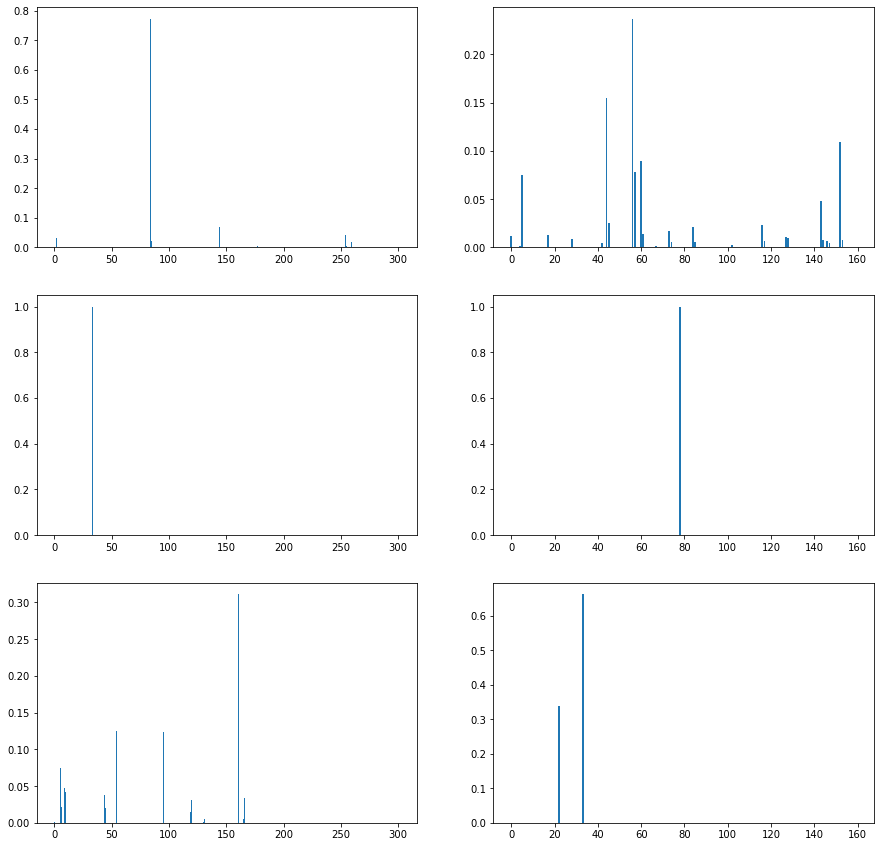

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))
a1v2 = attention[0].cpu()
a2v1 = attention[1].cpu()

for i in range(3):
    ax[i][0].bar(range(a2v1[i].size(0)), a2v1[i].numpy())
    ax[i][1].bar(range(a1v2[i].size(0)), a1v2[i].numpy())